# Introducción

En este notebook se estudiará el uso de Redes de Neuronas Convolucionales (CNN) para la reconstrucción de imágenes de perros. Además se utilizarán y compararán algoritmos de escalado.

In [1]:
import os
import numpy as np
from PIL import Image
from PIL import ImageFilter

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf

import random
import pathlib
from IPython import display

import pandas as pd

import time
import glob

In [2]:
train_input_dir =  './Datasets/Train/input/*.jpg'
train_target_dir =  './Datasets/Train/target_256_256/*.jpg'
test_input_dir =  './Datasets/Test/input/*.jpg'
test_target_dir =  './Datasets/Test/target_256_256/*.jpg'

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 100

In [4]:
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.cast(img, tf.float32)
    img = (tf.cast(img, tf.float32) / 255)
    return img

In [5]:
def preprocess_image(file_path_input, file_path_target):
    input_img = load_image(file_path_input)
    target_img = load_image(file_path_target)
    return input_img, target_img

In [6]:
train_input_dataset = tf.data.Dataset.list_files(str(train_input_dir), shuffle=False)
train_target_dataset = tf.data.Dataset.list_files(str(train_target_dir), shuffle=False)
train_dataset = tf.data.Dataset.zip((train_input_dataset, train_target_dataset))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [7]:
test_input_dataset = tf.data.Dataset.list_files(str(test_input_dir), shuffle=False)
test_target_dataset = tf.data.Dataset.list_files(str(test_target_dir), shuffle=False)
test_dataset = tf.data.Dataset.zip((test_input_dataset, test_target_dataset))
test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [8]:
class CNN(tf.keras.models.Model):
    

    def __init__(self,input_dim):
        super(CNN,self).__init__()

        def downsample(filters,kernel_size=3):
            self.model.add(tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=1,activation='relu',padding='same'))
            self.model.add(tf.keras.layers.MaxPooling2D((2,2)))

        self.model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_dim),
        ])
        
        downsample(32)
        downsample(64)
        downsample(128)
        downsample(256)
        downsample(512)
        
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(1024,activation='relu'))

        self.model.add(tf.keras.layers.Dense(units=256*256*3,activation='sigmoid'))

        self.model.add(tf.keras.layers.Reshape(target_shape=(256, 256, 3)))
        
    def call(self, inputs, training=None, mask=None):
        return self.model(inputs)

In [9]:
conv = CNN((256,256,3))
conv.compile(loss = "mean_squared_error",optimizer='adam')

In [10]:
conv.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [11]:
history = conv.fit(train_dataset,epochs=20)

Epoch 1/20
100/100 [==============================] - 23s 160ms/step - loss: 0.0569
Epoch 2/20
100/100 [==============================] - 16s 157ms/step - loss: 0.0305
Epoch 3/20
100/100 [==============================] - 16s 158ms/step - loss: 0.0230
Epoch 4/20
100/100 [==============================] - 16s 158ms/step - loss: 0.0195
Epoch 5/20
100/100 [==============================] - 16s 159ms/step - loss: 0.0177
Epoch 6/20
100/100 [==============================] - 16s 159ms/step - loss: 0.0165
Epoch 7/20
100/100 [==============================] - 16s 158ms/step - loss: 0.0156
Epoch 8/20
100/100 [==============================] - 16s 158ms/step - loss: 0.0150
Epoch 9/20
100/100 [==============================] - 16s 158ms/step - loss: 0.0144
Epoch 10/20
100/100 [==============================] - 16s 159ms/step - loss: 0.0140
Epoch 11/20
100/100 [==============================] - 16s 157ms/step - loss: 0.0137
Epoch 12/20
100/100 [==============================] - 16s 158ms/step - lo

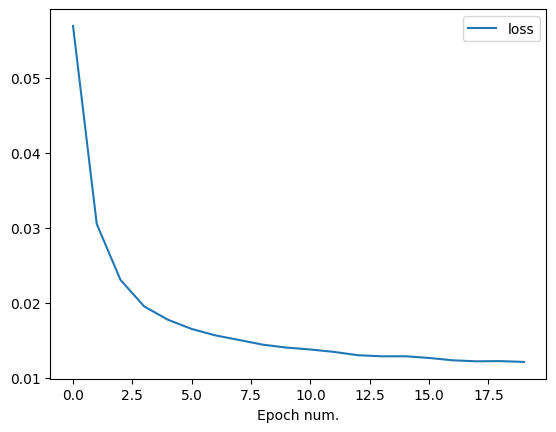

In [12]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

In [13]:
def generate_images(i,t,model):
    
    prediction = model.predict(i)


    plt.figure(figsize=(15, 15))

    display_list = [i[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i])
        plt.axis('off')
plt.show()

TypeError: shuffle() missing 1 required positional argument: 'buffer_size'

1/1 [==============================] - 0s 19ms/step


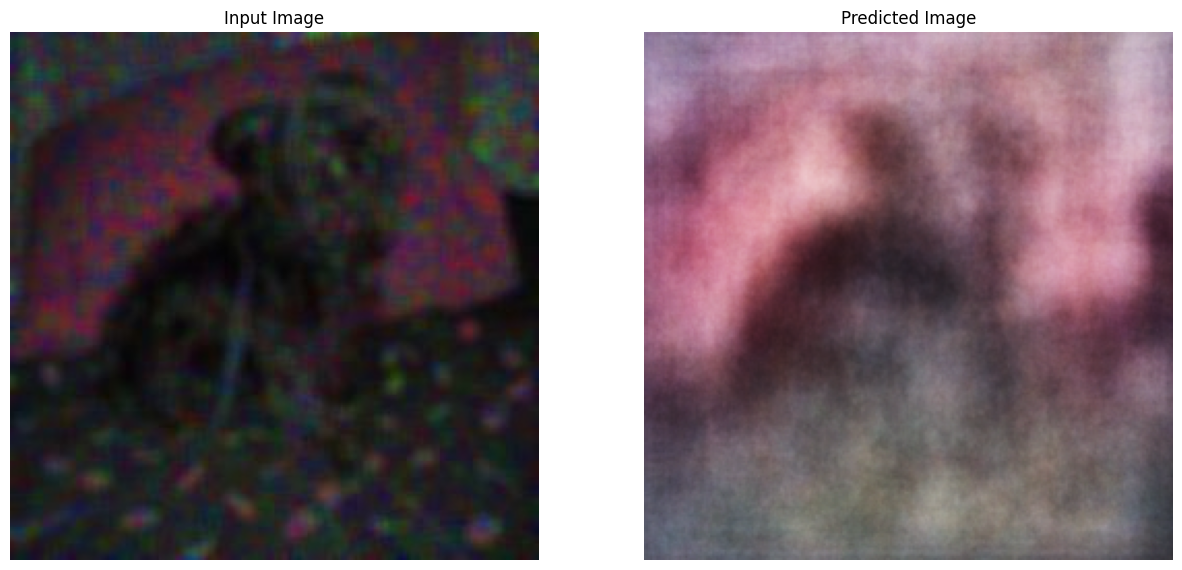

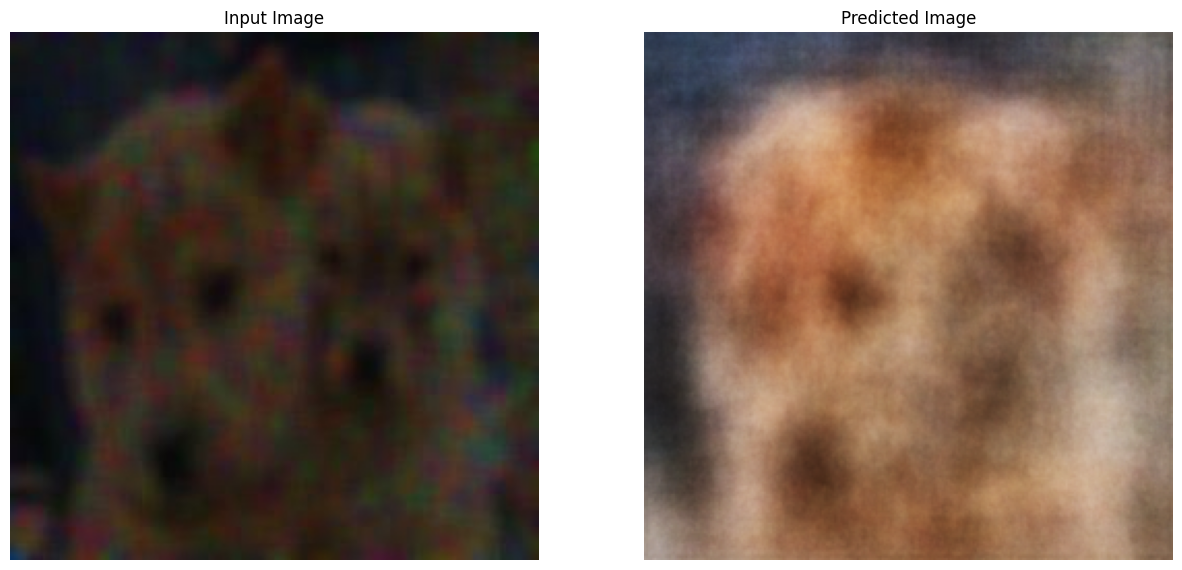

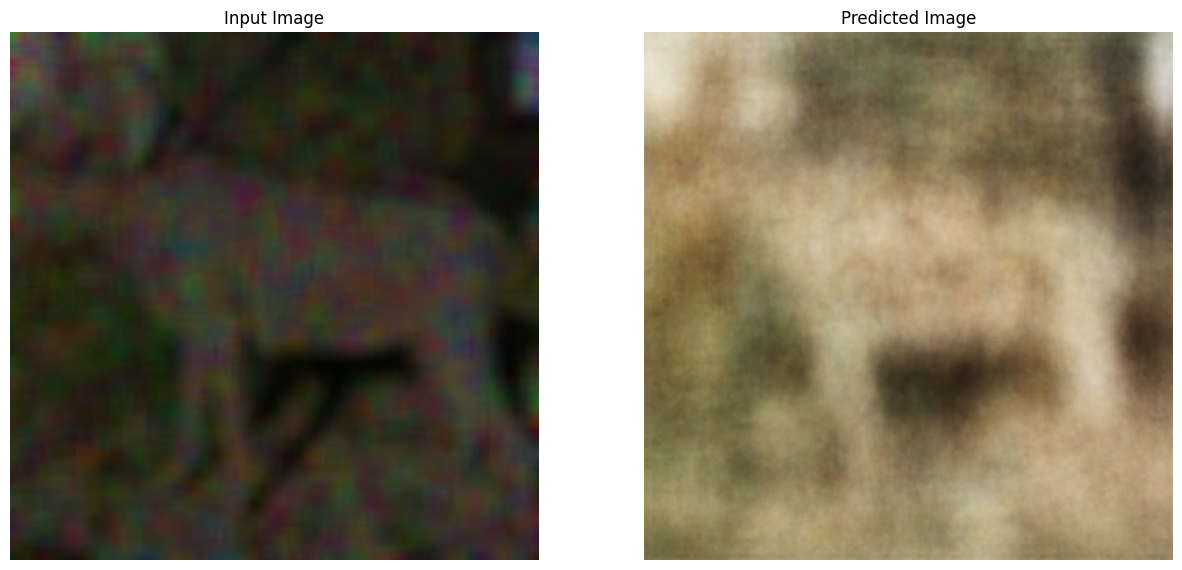

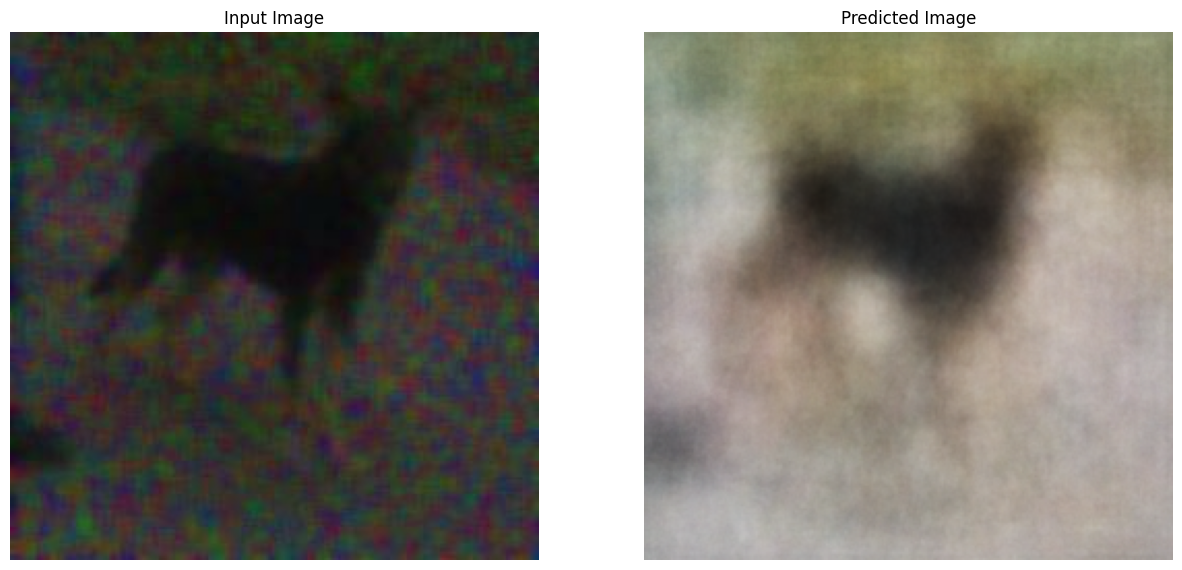

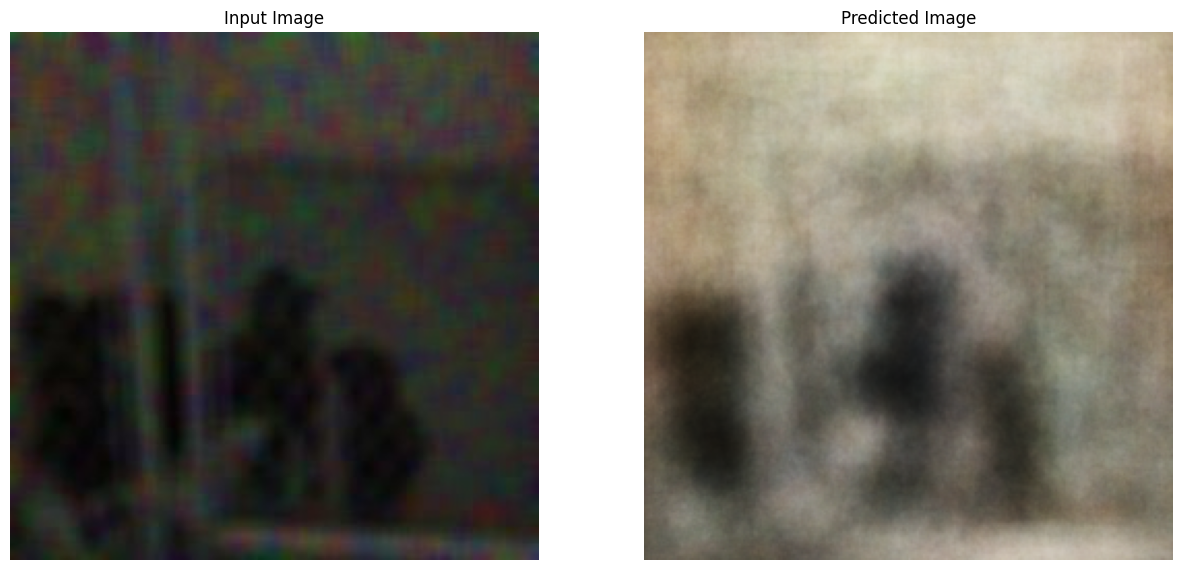

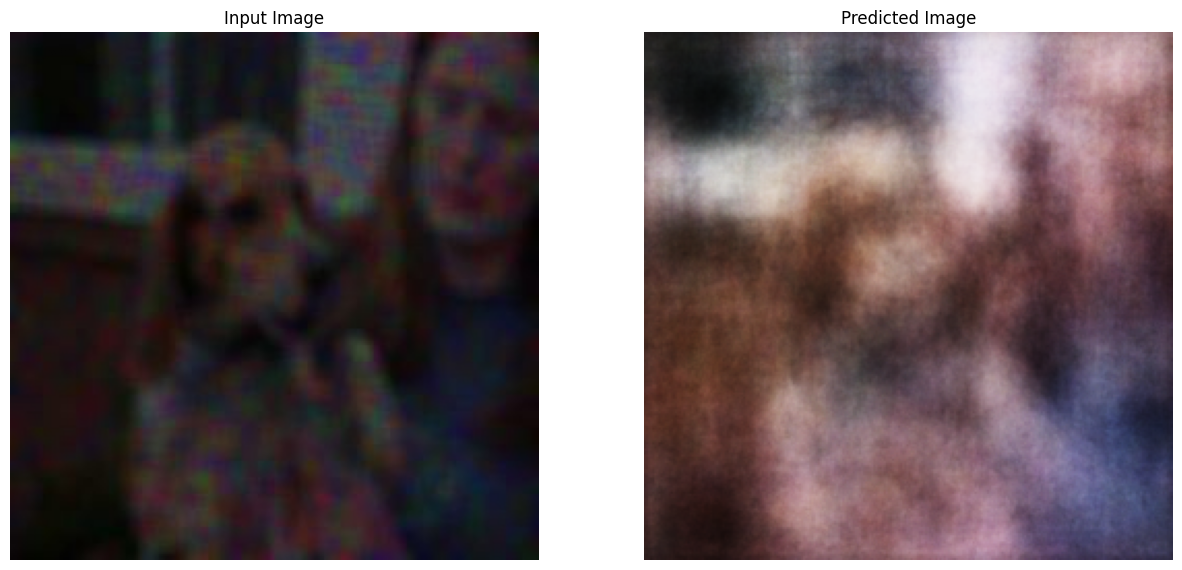

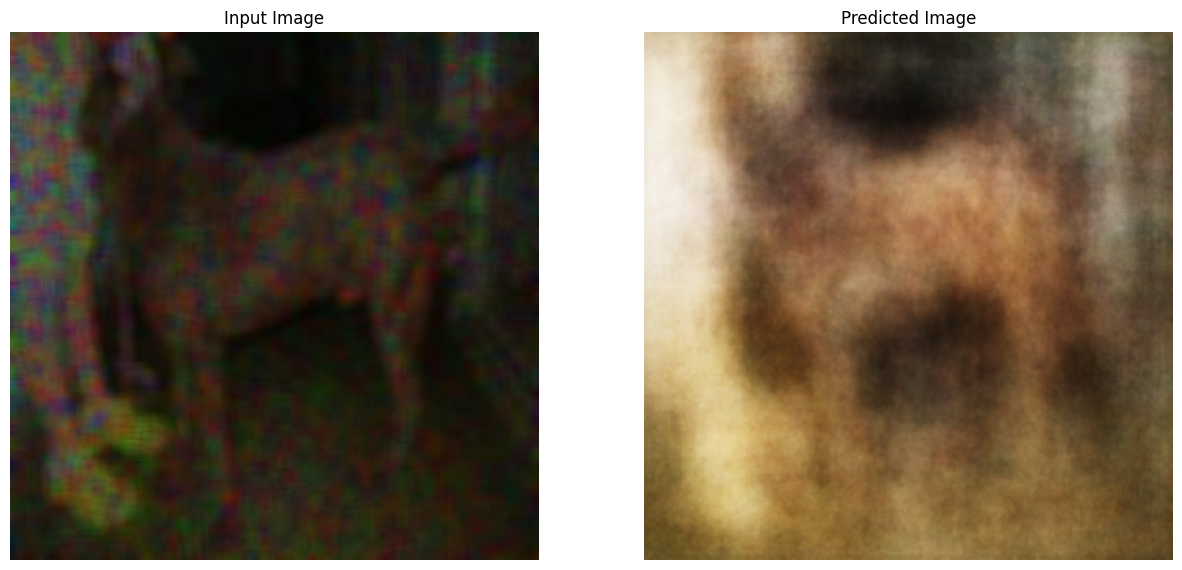

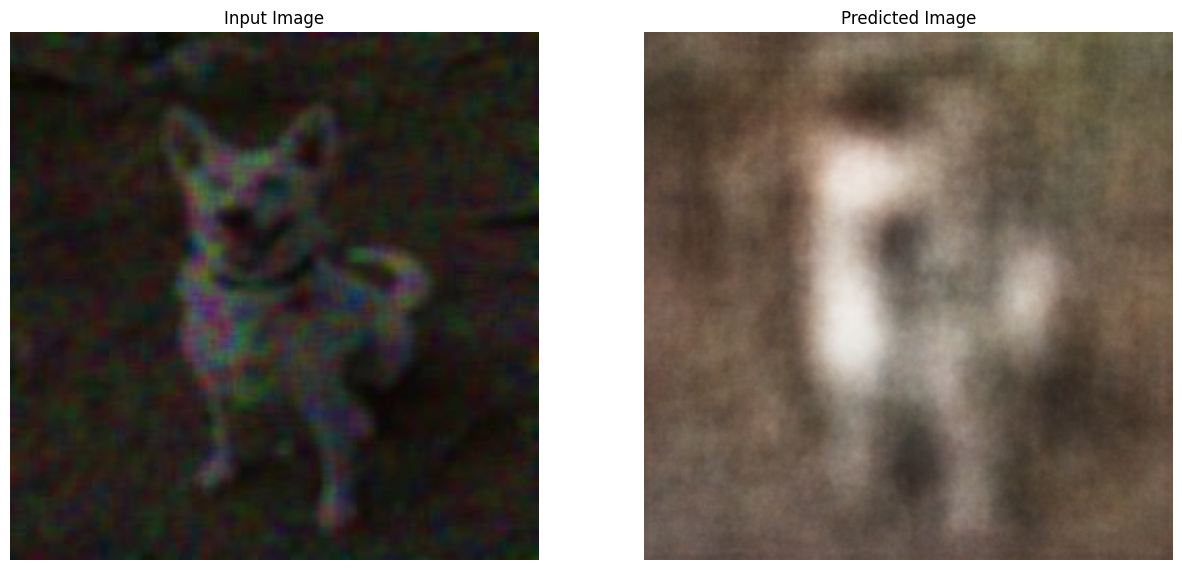

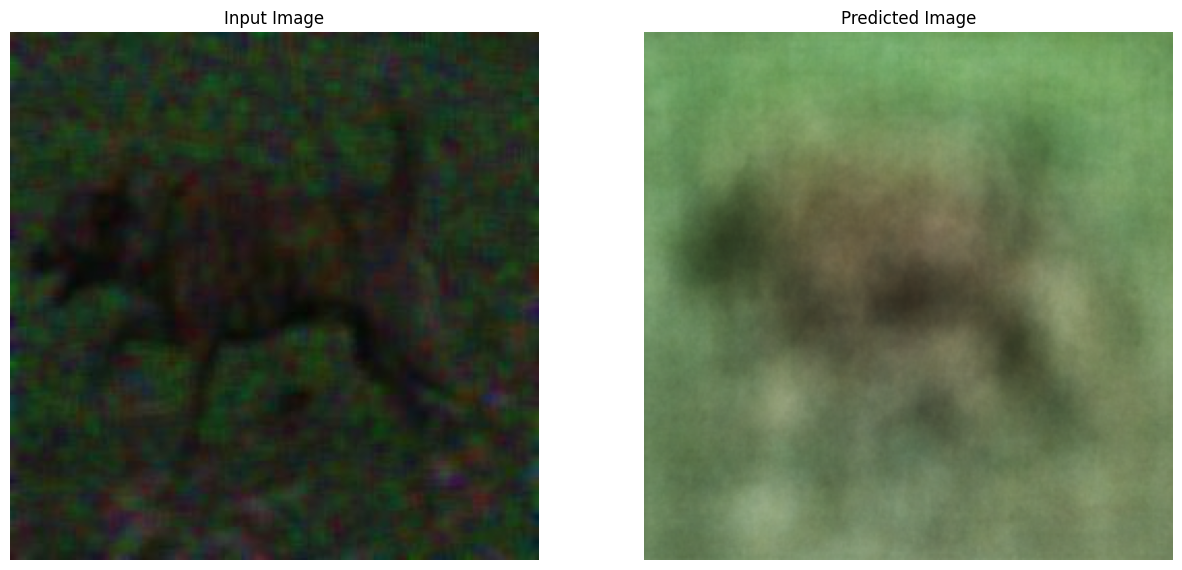

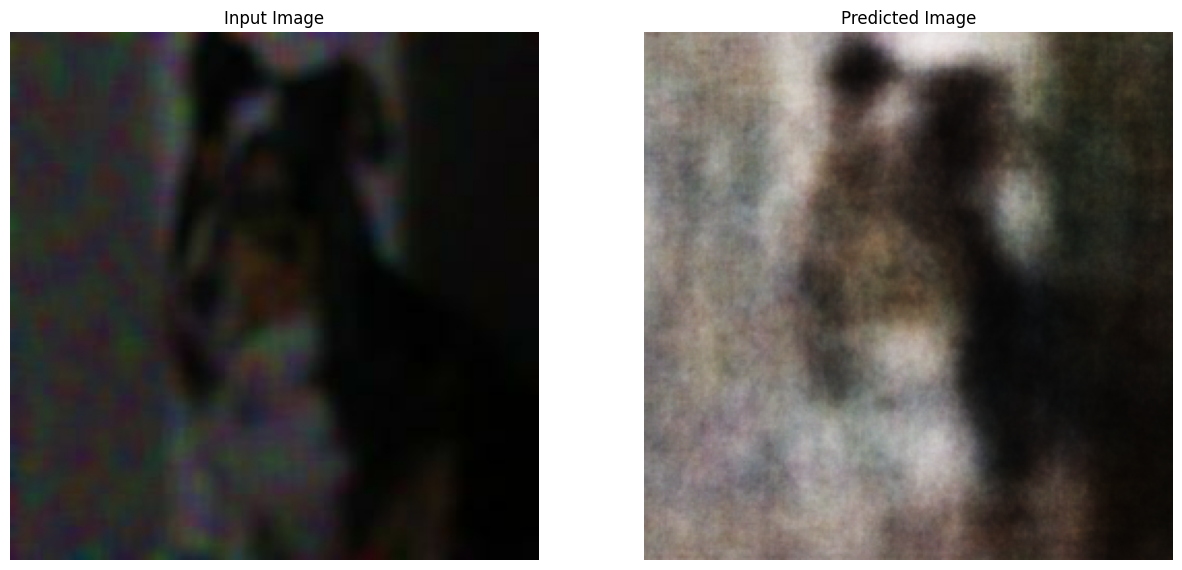

In [17]:
for i,t in train_dataset.take(10):

    i = np.expand_dims(i[0], axis=0)
    t = np.expand_dims(t[0], axis=0)

    generate_images(i,t,conv)
